# Tutoriel sur les systèmes de recommandation
### (initialement pour l'atelier sur le sujet organisé par IVADO à l'été 2019)


# Factorisation matricielle &mdash; réponses

## Auteurs: 

David Berger (davidberger2785 [at] gmail [dot] com)

Laurent Charlin (lcharlin [at] gmail [dot] com)

# 1. Introduction

Cet atelier se veut une introduction aux systèmes de recommandation. Plus spécifiquement, nous proposons d'implémenter dans un premier temps un système de recommandation basé sur la factorisation matricielle. Ce type d'architecture étant fortement associé à la <a href="https://en.wikipedia.org/wiki/Netflix_Prize">compétition Netflix</a>, nous utiliserons la base de données <a href="https://grouplens.org/datasets/movielens/"> MovieLens</a> afin d'entraîner nos modèles et de mener certaines expériences.

## 1.1 Installation des librairies

Avant de commencer, nous devons nous assurer d'installer les librairies nécessaires pour le tutoriel à l'aide de `pip`.  Pour ce faire, exécutez la cellule suivante en la sélectionnant et en cliquant `Shift`+`Enter`. Ceci peut prendre quelques minutes.

In [1]:
!rm -rf RS-Workshop
!git clone https://github.com/davidberger2785/RS-Workshop

Cloning into 'RS-Workshop'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 49 (delta 14), reused 47 (delta 12), pack-reused 0
Receiving objects: 100% (49/49), 1.17 MiB | 4.28 MiB/s, done.
Resolving deltas: 100% (14/14), done.


Afin de vous assurer que l'installation a eu lieu, importez toutes les librairies et modules dont nous nous servirons pour cet atelier en exécutant la prochaine cellule.

In [2]:
import numpy as np
import pandas as pd

# Data vizualisation
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# Homemade functions
import utilities as utl

Nous avons également écrit quelques fonctions passe-partout que nous avons regroupées dans la librairie `utilities`.

## 1.2 Objectif

De façon générale, l'objectif d'un système de recommandation est, comme son nom l'indique, d'effectuer des recommandations personnalisées à chacun de ses utilisateurs (usagers). Idéalement, ces recommandations devront être bonnes, bien que ce concept puisse rapidement devenir flou. Contrairement à d'autres tâches en apprentissage automatique, telle la reconnaissance d'images de chats ou la prédiction du cours d'une action en bourse, effectuer des recommandations de manière à aider un usager est d'autant plus complexe que ce problème est plus ou moins bien défini. Cherchons-nous à présenter à un utilisateur précis des suggestions le confortant dans ses choix antérieurs? Ou encore, voulons-nous lui présenter des suggestions complémentaires ou totalement indépendantes des items précédemment considérés? Enfin, tenterons-nous plutôt de lui présenter des items auxquels il n'a pas encore été exposé? Chacune de ces options sont légitimes et pourront être modélisées. Sans perte de généralités, le schéma ci-dessous modélise simplement la problématique des systèmes de recommandation sous l'angle de l'apprentissage automatique.

<img src="../Images/High_level_1.png" width="500">

N'empêche, dans le cadre de cet atelier et en considérant le contexte dans lequel nous sommes plongés, soit la suggestion de films comme le font Netflix ou Amazon Prime, nous pouvons réduire le problème à une tâche relativement simple: recommander des films que l'utilisateur va aimer en fonction de ses intérêts passés. Afin de mener à bien cette tâche, nous utiliserons l'ensemble des préférences des usagers, certaines variables sociodémographiques associées de même que certaines caractéristiques des films. Enfin, nous pouvons raffiner le schéma ainsi: 

<img src="../Images/High_level_2-2.png" width="750">

## 1.3 Jeu de données  - MoviesLens 100k

Les données que nous allons manipuler afin d'explorer différents types de systèmes de recommandation sont celles associées au projet <a href="https://grouplens.org/datasets/movielens/"> MovieLens</a>. Brièvement, les données utilisées consistent ici en plus ou moins 100&#8239;000 évaluations de films effectuées par 943 utilisateurs et où un ensemble de 1&#8239;682 films étaient disponibles en visionnement. En plus des 100 000 évaluations à notre disposition, nous avons des informations complémentaires liées à chacun des usagers de même qu'à chacun des films.

En somme, nous allons utiliser un total de trois jeux de données afin de mener à bien nos analyses soit: 

<ul>
<li> Users : contenant des informations associées aux caractéristiques des utilisateurs,
<li> Movies : contenant des informations associées aux caractéristiques des films en visionnement,
<li> Ratings : contenant l'ensemble des 100&#8239;000 évaluations effectuées par les utilisateurs.
</ul>

Nous utiliserons la librairie <a href="https://pandas.pydata.org/">Pandas</a> pour télécharger la base de données.

### 1.3.1 Users: Importation et prétraitement des données

In [3]:
# Téléchargement des données
ROOT_DIR = 'RS-Workshop/'
DATA_DIR = os.path.join(ROOT_DIR, 'data/ml-100k/')

users = pd.read_csv(os.path.join(DATA_DIR, 'u.user'), 
                        sep='|', header=None, engine='python', encoding='latin-1')
# Nous définissons les différentes variables en fonction de l'information fournie 
# dans le fichier 'readme'
users.columns = ['Index', 'Age', 'Gender', 'Occupation', 'Zip code']

# Bref aperçu
users.head()

,Index,Age,Gender,Occupation,Zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Avant de présenter les statistiques descriptives liées à la population étudiée, nous allons dans un premier temps traiter les données associées aux usagers sous la forme d'une <a href="https://fr.wikipedia.org/wiki/Liste_(informatique)"> <b> liste</b></a> afin de pouvoir plus aisément les manipuler. Notons que l'occupation de chaque individu étant une chaîne de caractères, nous avons recodé les 21 occupations possibles en booléen.

In [4]:
# Nombre d'utilisateurs et d'utilisatrices
nb_users = len(users)

# Sexe
gender = np.where(np.matrix(users['Gender']) == 'M', 0, 1)[0]

# Occupation
occupation_name = np.array(pd.read_csv(os.path.join(DATA_DIR, 'u.occupation'), 
                                       sep='|', header=None, engine='python', 
                                       encoding='latin-1').loc[:, 0])

# Recodage en booléen de la variable occupation
occupation_matrix = np.zeros((nb_users, len(occupation_name)))

for k in np.arange(nb_users):
    occupation_matrix[k, occupation_name.tolist().index(users['Occupation'][k])] = 1

# Concatenation des différentes données sociodémographiques sous forme de liste
user_attributes = np.concatenate((np.matrix(users['Age']), np.matrix(gender), 
                                  occupation_matrix.T)).T.tolist()

Nous explorons par la suite les différentes statistiques descriptives associées aux usagers. Celles-ci comportent des informations en lien avec l'âge (variable continue), le sexe (variable binaire) et l'occupation de chacun des usagers (au nombre de 21, toutes binaires). 

Statistiques descriptives associées à l'âge.

In [5]:
pd.DataFrame(users['Age'].describe()).T

,count,mean,std,min,25%,50%,75%,max
Age,943.0,34.051962,12.19274,7.0,25.0,31.0,43.0,73.0


Diagramme à bandes pour la statistique associée au sexe.

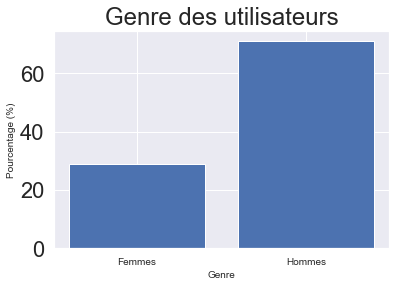

In [6]:
utl.barplot(['Femmes', 'Hommes'], 
            np.array([np.mean(gender), 1 - np.mean(gender)]) * 100, 
            'Genre', 'Pourcentage (%)', "Genre des utilisateurs", 0)

Diagramme à bandes pour la statistique associée à l'occupation des individus.

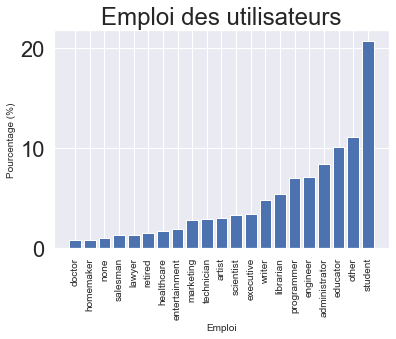

In [7]:
attributes, scores = utl.rearrange(occupation_name, 
                                   np.mean(occupation_matrix, axis=0) * 100)
utl.barplot(attributes, scores, 'Emploi', 'Pourcentage (%)', 
            "Emploi des utilisateurs", 90)

### 1.3.2 Movies: Importation et reformatage des données

De la même façon, nous allons traiter et explorer les données associées aux films. Pour chacun d'eux, nous disposons du titre, de la date de sortie en Amérique du Nord, de même que les genres auxquels il est associé.

In [8]:
movies = pd.read_csv(os.path.join(DATA_DIR, 'u.item'), sep='|', 
                     header=None, engine='python', encoding='latin-1')

# Number of movies
nb_movies = len(movies)

# Genres
movies_genre = np.matrix(movies.loc[:, 5:])
movies_genre_name = np.array(pd.read_csv(os.path.join(DATA_DIR, 'u.genre'), sep='|', 
                                         header=None, engine='python', 
                                         encoding='latin-1').loc[:, 0])

# Quick overview
movies.columns = ['Index', 'Title', 'Release', 'The Not a Number column', 'Imdb'] +
                  movies_genre_name.tolist()
movies.head()

,Index,Title,Release,The Not a Number column,Imdb,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Nous présentons les proportions de films en fonction du genre comme statistique descriptive.

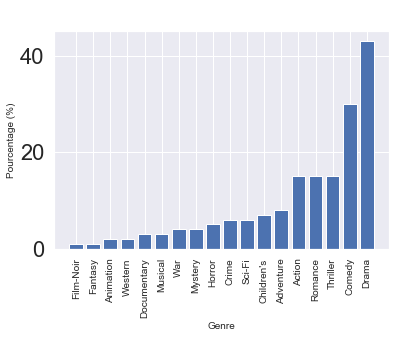

In [9]:
attributes, scores = utl.rearrange(movies_genre_name, 
                                   np.array(np.round(np.mean(movies_genre, axis=0) * 1,
                                                     2))[0])
utl.barplot(attributes, np.array(scores) * 100, xlabel='Genre', 
            ylabel='Pourcentage (%)', 
            title=" ", rotation = 90)

### 1.3.3 Ratings: Importation et traitement des données

La base de données comportant les évaluations des films effectuées par les usagers est constituée d'environ 100 000 lignes (une évaluation par ligne) où sont respectivement recensés le numéro d'identification de l'utilisateur, le numéro d'identification du film, l'évaluation associée et un marqueur de temps auquel le film a été visionné. Les ensembles d'entraînement et de test ont été fournis tels quels, c'est-à-dire que nous n'avons pas besoin de les construire nous-mêmes, et comportent respectivement 80 000 et 20 000 évaluations.

Pour des raisons pratiques, nous convertissons la base de données sous la forme d'une liste grâce à la fonction maison `convert`. 

In [10]:
training_set = np.array(pd.read_csv(os.path.join(DATA_DIR, 'u1.base'), delimiter='\t'), 
                        dtype='int')
testing_set = np.array(pd.read_csv(os.path.join(DATA_DIR, 'u1.test'), delimiter='\t'), 
                       dtype='int')

train_set = utl.convert(training_set, nb_users, nb_movies)
test_set = utl.convert(testing_set, nb_users, nb_movies)

Comme nous l'avons fait auparavant, nous pouvons obtenir quelques statistiques descriptives associées aux évaluations. Dans un premier temps, il pourrait être intéressant d'étudier les tendances moyennes des individus.

##### Question 1

1. Quels autres types de statistiques pourraient être intéressantes?

##### Réponse 1

1. Nous pourrions définir les différentes statistiques ci-dessous en fonction d'autres attributs, tels le sexe des usagers, leur occupation ou encore leur âge.

In [11]:
train_matrix = np.array(train_set)
shape = (len(train_set), len(train_set[0]))
train_matrix.reshape(shape)
train_matrix_bool = np.where(train_matrix > 0 , 1, 0)

user_watch = np.sum(train_matrix_bool, axis=1)
pd.DataFrame(user_watch).describe().T

,count,mean,std,min,25%,50%,75%,max
0,943.0,84.834571,83.805787,4.0,27.0,50.0,115.0,685.0


Avec un petit histogramme...

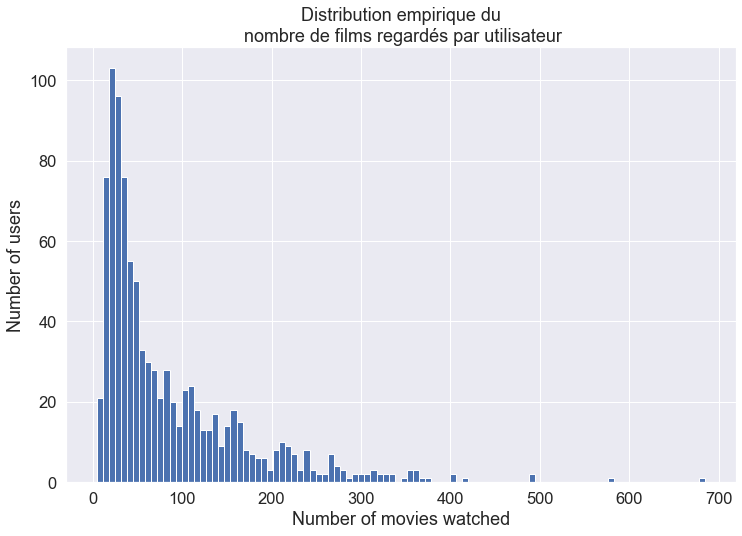

In [12]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)

plt.title('Distribution empirique du\n nombre de films regardés par utilisateur')
plt.xlabel('Number of movies watched')
plt.ylabel('Number of users')
plt.hist(user_watch, 100);

Nous présentons finalement quelques statistiques associées aux films.

In [13]:
movie_frequency = np.mean(train_matrix_bool, axis=0)
pd.DataFrame(movie_frequency).describe().T

,count,mean,std,min,25%,50%,75%,max
0,1682.0,0.050437,0.068664,0.0,0.005302,0.022269,0.066808,0.513256


##### Question 2

1. Quelles statistiques ou observations pourraient nous paraître pertinentes? Pourquoi? 
2. Quel type de statistique pourrait être plus approprié dans un tel contexte?

##### Réponse 2

1. Un simple coup d'oeil à l'histogramme ci-dessous, nous constatons qu'environ 25% des films ont été visionnés par moins de 1% de la population. Certains films ont été visionnés par une grande majorité. En fait, c'est assez difficile de définir une tendance, puisqu'il y a des événements rares comme les blockbusters tel <i>Histoire de jouets</i> et une grande quantité de valeurs pratiquement nulles. Dans tous les cas, les statistiques les moins pertinentes à nos yeux sont la moyenne et l'erreur standard.
2. Toutes statistiques descriptives robustes aux événements rares.

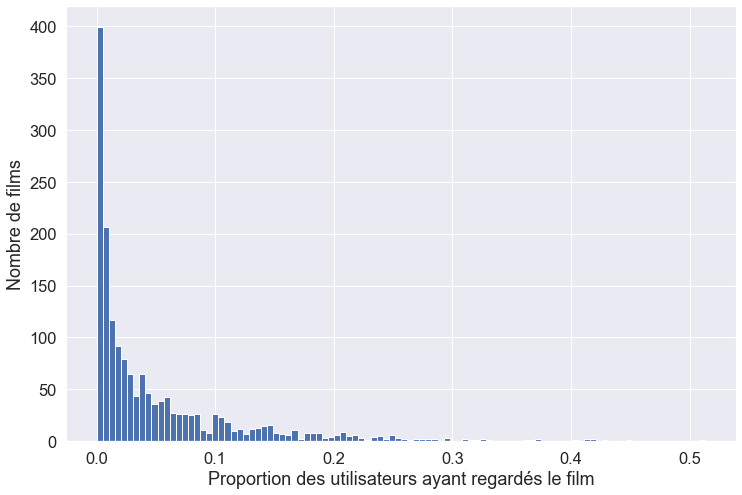

In [14]:
plt.xlabel('Proportion des utilisateurs ayant regardés le film')
plt.ylabel('Nombre de films')
plt.hist(movie_frequency, 100);

#### Étude des préférences individuelles en fonction du type de film

Nous pourrions également nous intéresser au comportement d'un individu en particulier. Entre autres choses, nous pourrions étudier s'il y a un biais associé à son schème d'évaluation ou encore quelles sont ses préférences cinématographiques en fonction du score attribué.

In [15]:
def stats_user(data, movies_genre, user_id):
    
    ratings = data[user_id]
    stats = np.zeros(6)
    eva = np.zeros((6, movies_genre.shape[1]))

    for k in np.arange(len(ratings)):
        index = int(ratings[k])
        stats[index] += 1
        eva[index, :] = eva[index, :] + movies_genre[k]

    return stats, eva

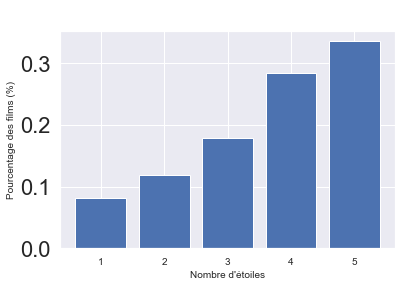

In [16]:
user_id = 0
stats, eva = stats_user(train_set, movies_genre, user_id)
utl.barplot(np.arange(5) + 1, stats[1:6] / sum(stats[1:6]), xlabel="Nombre d'étoiles", 
            ylabel='Pourcentage des films (%)', 
            title=" ", rotation = 0)

##### Question 3

1. Comment vérifier qu'il existe un biais associé au schème d'évaluation d'un individu?

##### Réponse 3

1. Une façon simple serait d'effectuer un test-t afin de vérifier sur le score moyen d'un individu est significativement différent de ceux de l'ensemble d'une population.

## 1.5 Création des sous-ensembles d'entraînement et de validation

En apprentissage automatique, nous manipulons des <a href="https://blogs.nvidia.com/blog/2018/04/15/nvidia-research-image-translation/">bases de données complexes</a> pour lesquelles nous tentons de définir des espaces de fonctions tout aussi complexes dans le but d'accomplir une tâche précise. Ceci étant, ces espaces de fonctions sont définis par un ensemble de paramètres dont le nombre tend à augmenter avec la complexité des données. Une fois l'espace défini par un ensemble de paramètres fixés, nous pouvons varier les différentes valeurs d'hyperparamètres afin d'explorer empiriquement les espaces de fonctions. Pour choisir l'ensemble des paramètres et d'hyperparamètres optimaux, nous définissons une métrique nous permettant d'évaluer le modèle; par exemple, à quel point l'image d'un chat nous paraît vraisemblable. 

Dans la mesure où nous voulons développer un modèle capable de généraliser l'évaluation de ses performances et la sélection des hyperparamètres doit se faire sur un ensemble de données indépendant, mais issues de la même distribution, de l'ensemble sur lequel il a appris. Pareil ensemble porte le nom **d'ensemble de validation**.

<b>! Remarque !</b> 

La notion d'ensemble d'entraînement et de test dans le cadre de système de recommandation est quelque peu différente de ce que l'on voit habituellement avec les problèmes dits supervisés. Si dans le cadre d'un problème supervisé, l'ensemble de test consiste essentiellement en de nouvelles observations (lire « lignes de la matrice des observations ») indépendantes des observations préalablement observées dans l'ensemble d'entraînement, le paradigme est sensiblement différent lorsque nous travaillons avec des systèmes de recommandation.

Effectivement, **les données appartenant à l'ensemble de test ne sont pas liées à un nouvel individu, mais bien à de nouvelles évaluations, faites par le même ensemble d'individus et jusqu'alors inobservées**. Dès lors, les données associées aux ensembles d'entraînement, de validation et de test ne sont plus indépendantes telles que supposées (la fameuse hypothèse <i> iid </i>); ce qui complique théoriquement les choses.

Puisque le but de l'atelier n'est pas d'étudier la notion de biais associée au type de dépendance entre les différentes évaluations dans les systèmes de recommandation, nous allons naïvement supposer que chacune des évaluations est indépendante des autres. N'empêche, dans un cadre pratique, ignorer ce genre de considérations pourra éventuellement biaiser les algorithmes.

In [17]:
def split(data, ratio, tensor=False):
    train = np.zeros((len(data), len(data[0]))).tolist()
    valid = np.zeros((len(data), len(data[0]))).tolist()

    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] > 0:
                if np.random.binomial(1, ratio, 1):
                    train[i][j] = data[i][j]
                else:
                    valid[i][j] = data[i][j]

    return [train, valid]

train = split(train_set, 0.8)
test = test_set

# 2. Système de recommandation: factorisation matricielle 

## 2.1 Modèle

La factorisation matricielle (FM) suppose que chaque évaluation observée $r_{ui}$ pour $1 \leq u \leq |U|$ et $1 \leq i \leq |I|$, où $|U|$ et $|I|$ dénotent respectivement le nombre total d'usagers et d'items, peut être estimée en considérant un modèle latent. Cette modélisation s'avère être une estimation $\hat{r}_{ui}$ de l'observation associée $r_{ui}$ et est définie par:

$$
\begin{align}
\hat{r}_{ui} =  \langle p_{u}, q_{i} \rangle, 
\end{align}
$$

où $\langle \cdot \rangle$ symbolise le produit scalaire alors que $p_{u}$ et $q_{i}$ sont les représentations latentes sous forme vectorielle associées à l'usager $u$ et à l'item $i$. L'intuition derrière cette représentation suggère que chaque évaluation peut être estimée en considérant une caractérisation latente des usagers et des items. 

À titre d'exemple, fixons le nombre de variables latentes à trois et supposons encore que celles-ci sont associées à i) la popularité du film au box-office, ii) sa durée et finalement iii) son niveau de romantisme. Définissons l'usager $u$ comme étant un adolescent de 15 ans aimant les films populaires, relativement courts et très macabres. Nous pourrons modéliser le vecteur latent associé par:

$$
\begin{align}
p_{u} = [1, 0, 0]^T.
\end{align}
$$

Supposons maintenant que le film $i$ s'avère être <i>Le Roi lion</i> auquel est associée la modélisation suivante:

$$
\begin{align}
q_{i} = [1, 0.5, 0]^T.
\end{align}
$$

L'estimation de l'évaluation pour cet usager et item précis en fonction des représentations latentes sera donc:

$$
\begin{align}
\hat{r}_{ui} =  \langle p_u, q_i \rangle = 1.
\end{align}
$$

Le principal défi dans ce type de modélisation est de définir l'ensemble des vecteurs latents associés aux usagers, regroupés sous la forme matricielle par $\mathbf{P}_{|U|\times k} = [p_1, p_2, ..., p_k]$, et aux items, regroupés sous la forme matricielle par $\mathbf{Q}_{|I|\times k} = [q_1, q_2, ..., q_k]$. 
 
Puisque le problème initial consiste à présenter les estimations les plus justes, et donc à calculer $\mathbf{P}$ et $\mathbf{Q}$ de manière à minimiser la distance entre la totalité des évaluations observées $r_{ui}$ et leur estimation $\hat{r}_{ui}$, nous pouvons définir la tâche à accomplir avec le problème d'optimisation suivant:

$$
\begin{align}
\mathbf{P}, \mathbf{Q} = \underset{p, q}{\operatorname{argmin}} \sum_{r_{ui} \neq 0} (r_{ui} - \hat{r}_{ui})^2 = \underset{p, q}{\operatorname{argmin}}  \sum_{r_{ui} \neq 0} (r_{ui} - \langle p_u, q_i \rangle)^2.
\end{align}
$$

Au problème d'optimisation ci-dessus, nous ajouterons une contrainte sur les variables latentes, afin de forcer les vecteurs associés à avoir de petites composantes:

$$
\begin{align}
\mathbf{P}, \mathbf{Q} = \underset{p, q}{\operatorname{argmin}} \sum_{r_{ui} \neq 0} \{(r_{ui} - \langle p_u, q_i \rangle)^2 + \lambda(||p_u||^2 + ||q_i||^2)\},
\end{align}
$$

où $\lambda$ est la régularisation, plus souvent nommé <i>weight decay</i> en apprentissage profond ou encore multiplicateur de Lagrange en mathématiques. 

De façon générale, le problème d'optimisation ci-dessus, qui s'avère à factoriser une matrice creuse, ne peut se résoudre aussi facilement qu'à l'aide des moindres carrés comme c'est le cas dans le cadre de la régression linéaire par exemple. Deux méthodes seront présentées au cours de ce tutoriel pour estimer les matrices $\mathbf{P}$ et $\mathbf{Q}$.

## 2.2 Implémentation

Afin de construire un système de recommandation basé sur la factorisation matricielle, nous devrons définir quelques fonctions nécessaires à ce type d'algorithme. Globalement, nous pouvons décliner l'algorithme de factorisation matricielle en trois étapes:
<r>

1. <b> Boucle d'apprentissage</b>: Passe en revue chacune des évaluations en boucle jusqu'à ce que le modèle estimé ne varie que légèrement d'une itération à l'autre en fonction d'un critère choisi.
2. <b> Estimation</b>:  Estimation des matrices de facteurs $\mathbf{P}$ et $\mathbf{Q}$ respectivement associées aux users et aux items.
3. <b> Évaluation</b>: Évaluation de la performance du modèle en fonction d'une métrique choisie.


### 2.2.1 Boucle d'apprentissage

La fonction consiste simplement à passer en boucle les différentes évaluations jusqu'à ce qu'un critère d'arrêt donné soit respecté.

##### Question 4

1. Dans le cas des estimateurs obtenus via la descente de gradient stochastique (SGD), quelle condition devrions-nous rajouter à la ligne 17? Et pourquoi?
2. À la fin de chaque époque, quelle statistique serait-il préférable de calculer? Codez-la. Remarque : il est préférable d'initialiser des objets en début de fonction (voir ligne 6).
3. Donnez deux raisons pour lesquelles ces statistiques sont utiles.
4. Le critère d'arrêt pour éviter le surapprentissage à la ligne 30 est plutôt naïf. Pourquoi?
5. Développez un nouveau critère d'arrêt.

##### Réponse 4

1. Tel que présenté dans la présentation du modèle, seules les évaluations observées, et donc les valeurs non nulles de la matrice $\mathbf{R}$ sont considérées.
2. En ce qui nous concerne, l'erreur quadratique moyenne sur les ensembles d'entraînement et de validation devra être calculée. De façon générale, après chaque époque, nous calculerons la fonction de perte sur les différents ensembles (mais pas celle associée à l'ensemble de test!). 
3. Sous l'hypothèse qu'une fonction de coût est monotone sur l'ensemble d'entraînement (bref que le modèle s'améliore constamment sur cet ensemble), il est fort probable que celui-ci va surapprendre ce même ensemble. Afin de contrecarrer cette difficulté, un critère d'arrêt peut jouer le rôle de garde-fou contre le surapprentissage. Enfin, la deuxième raison est plutôt de nature computationnelle; il peut être intéressant que l'algorithme s'arrête après un certain temps et nous fournisse un modèle...
4. Le critère ne considère qu'une seule valeur. Cette valeur nous semble un peu aléatoire; est-ce beaucoup ou est-ce trop peu considérant la vraisemblance des données que nous manipulons?
5. Le nouveau critère prend en compte la dernière remarque. En fait, nous proposons de considérer la différence entre les deux dernières entrées associée à l'ensemble d'entraînement.

In [18]:
def learn_to_recommend(data, features=10, lr=0.0002, epochs=101, weight_decay=0.02, 
                       stopping=0.001):
    """
    Args:
      data: ensemble des évaluations
      features: variables latentes
      lr: learning rate pour la descente de gradient
      epochs: nombre d'iterations ou boucles maximales à effectuer
      weight_decay: régularisation de type L2 afin de prédire des valeurs 
                    differentes de 0
      stopping: scalaire associé au critère d'arrête
      
    Returns:
      P: matrice latente associée aux usagers
      Q: matrice latente associée aux items
      loss_train: vecteur des valeurs de la fct perte après chaque itération sur train
      loss_valid: vecteur des valeurs de la fct perte après chaque itération sur valid
      """
    
    
    train, valid = data[0], data[1]
    nb_users, nb_items = len(train), len(train[0])

    # Réponse 4.2: Liste à initialiser 
    loss_train, loss_valid = [], []
    
    P = np.random.rand(nb_users, features) * 0.1
    Q = np.random.rand(nb_items, features) * 0.1
    
    for k in range(epochs):        
        for i in range(nb_users):
            for j in range(nb_items):

                # Réponse 4.1: codez la condition sur cette ligne
                if train[i][j] > 0:
                    eij = train[i][j] - prediction(P, Q, i, j)
                    P, Q = sgd(eij, P, Q, i, j, features, lr)
                               
        # Questions 4.2: Codez la statistique
        loss_train.append(loss(train, P, Q))
        loss_valid.append(loss(valid, P, Q))
        
        if k % 10 == 0:
            print('Epoch : ', "{:3.0f}".format(k+1), 
                  ' | Train :', "{:3.3f}".format(loss_train[-1]), 
                  ' | Valid :', "{:3.3f}".format(loss_valid[-1]))

        # Question 4.4: 
        if abs(loss_train[-1]) < stopping:
            break
            
        # Question 4.5: Nouveau critère d'arrêt
        #if abs(loss_valid[-1] - loss_valid[-2]) < 0.001:
        #    break
        
    return P, Q, loss_train, loss_valid

### 2.2.2 Fonction de coût

La fonction de coût joue un rôle déterminant dans la construction d'un modèle prédictif. En effet, c'est cette même fonction de coût que nous essaierons de minimiser (ou maximiser c'est selon) en ajustant de façon itérative les valeurs des matrices latentes.

Dans la mesure où l'on considère que les évaluations considérées varient entre 1 et 5, l'erreur quadratique moyenne (EQM) semble une première option intéressante. Formellement, dans le cadre d'un système de recommandation, nous définirons l'EQM ainsi : 

$$
\begin{align}
EQM (\mathbf{R}, \hat{\mathbf{R}}) = \frac{1}{n} \sum_{r_{ui} \neq 0} (r_{ui} - \hat{r}_{ui})^2, 
\end{align}
$$

où $\mathbf{R}$ et $\hat{\mathbf{R}}$ sont respectivement les matrices des évaluations observées et prédites, <i>n</i> est le nombre total d'évaluations estimées. De la même façon, $r_{ui}$ et $\hat{r}_{ui}$ sont des scalaires associés respectivement à l'évaluation observée et l'évaluation estimée de l'usager $u$ pour l'item $i$.

##### Question 5

1. Supposons que nous voulons prédire l'évaluation de l'individu <i>i</i> pour le film <i>j</i>, comment devrions-nous nous y prendre? Implémentez la fonction prédiction.
2. Un détail important est manquant dans la fonction `loss` suivante. En quoi cette erreur est fondamentale? Corrigez-la.

##### Réponse 5

2. Il manque la condition sur les valeurs non nulles!

In [19]:
# Réponse 5.1: Implémentez la fonction prédiction
def prediction(P, Q, i, j):
    """
    Args:
       P: matrice des usagers
       Q: matrice des items
       i: indice associé à l'usager i
       j: indice associé à l'item j
    
    Returns:
       pred: l'évaluation prédite de l'usager i pour l'item j
       """
    return np.dot(P[i, :], Q[j, :])

def loss(data, P, Q):
    """
    Args:
       data: données
       P: matrice des usagers
       Q: matrice des items
       
    Returns:
        EQM: la moyenne observée des erreurs au carré
        """

    errors_sum, nb_evaluations = 0., 0

    for i in range(len(data)):
        for j in range(len(data[i])):
            
            # Réponse 5.2: Un détail important
            if data[i][j] > 0:
                errors_sum += pow(data[i][j] - prediction(P, Q, i, j), 2)
                nb_evaluations += 1
    return errors_sum / nb_evaluations

### 2.2.3 Estimation

La méthode d'estimation des paramètres du modèle est directement associée à la fonction de coût que nous essayons de minimiser. Avec la factorisation matricielle, deux techniques d'estimation sont disponibles afin de calculer les matrices latentes $\mathbf{P}$ et $\mathbf{Q}$ respectivement associées aux usagers et aux items. Dans tous les cas, ces techniques font appel à la linéarité du modèle de factorisation matriciel.

#### Descente du gradient

Dans un premier temps, nous implémentons la descente stochastique du gradient (SGD): une méthode itérative passant en revue l'ensemble des évaluations non nulles pour chacun des usagers.

Formellement, et en se rappelant que la fonction que nous essayons de minimiser est:

$$
\begin{align}
\underset{p, q}{\operatorname{min}} L(\mathbf{R}, \lambda) = \underset{p, q}{\operatorname{min}} \sum_{r_{ui} \neq 0} \{(r_{ui} - \langle p_u, q_i \rangle)^2 + \lambda \cdot (||p_u||^2 + ||q_i||^2)\},
\end{align}
$$

nous calculons que les gradients de la précédente équation en fonction de $p_u$ et $q_i$ sont:

$$
\nabla_{p_{u}} L(\mathbf{R}, \lambda) =  \epsilon_{ui} \cdot q_{i} - \lambda \cdot p_{u} \quad \text{et} \quad 
\nabla_{q_{i}} L(\mathbf{R}, \lambda) =  \epsilon_{ui} \cdot p_{u} - \lambda \cdot q_{i},
$$

où

$$
\epsilon_{ui} = r_{ui} - \hat{r}_{ui}. 
$$

Enfin, pour chaque itération, et dans la mesure où l'évaluation observée est non-nulle, chacune des mises à jours des vecteurs latentes pourra se faire ainsi:

$$
p_{u}^{(t+1)} \leftarrow p_{u}^{(t)} + \gamma \cdot (\epsilon_{ui} \cdot q_{i}^{(t)} - \lambda \cdot p_{u}^{(t)}) \\
q_{i}^{(t+1)} \leftarrow q_{i}^{(t)} + \gamma \cdot (\epsilon_{ui} \cdot p_{u}^{(t)} - \lambda \cdot q_{i}^{(t)}),
$$

où $p_{u}^{(t+1)}$ dénote la valeur de $p_{u}$ après la $t + 1$ ième itération et où $\gamma$ est le pas d'apprentissage (<i>learning rate</i>) de la descente. 

#### Remarques sur les moindres carrés alternés

La deuxième technique est basée sur les moindres carrés alternés (ALS). Cette méthode a ceci d'élégant qu'elle permet une forme analytique. Nous ne l'implémenterons pas dans le cadre de cet atelier.

##### Question 6

1. En considérant les équations associées à la descente du gradient, complétez la fonction `sgd` afin d'implémenter la descente stochastique du gradient. 

In [20]:
def sgd(error, P, Q, id_user, id_item, features, lr):
    """
    Args:
       error: différence entre l'évaluation observée et celle prédite (dans cet ordre)
       P: matrix of users
       Q: matrix of items
       id_user: id_user
       id_item: id_item
       features: nombre de variables latentes
       lr: pas d'apprentissage pour la descente du gradient
       
    Returns:
        P: la nouvelle estimation de P
        Q: la nouvelle estimation de Q
        """
    
    # Question 6.1 : Implémentez la SGD
    for l in range(features):
        P[id_user, l] = P[id_user, l] +
                          lr * (error * Q[id_item, l] - weight_decay * P[id_user, l])
        Q[id_item, l] = Q[id_item, l] + 
                          lr * (error) * P[id_user, l] - weight_decay * Q[id_item, l]
        
    return P, Q

## 2.3 Entraînement du modèle

La factorisation matricielle maintenant implémentée, nous pouvons commencer à entraîner le modèle avec différents paramètres et hyperparamètres. L'idée ici n'est pas d'ajuster les paramètres de façon telle à obtenir le meilleur modèle possible, mais simplement de comprendre le rôle que ceux-ci peuvent jouer, tant du point de vue du surapprentissage que du temps de calcul. En fait, ici, il n'y a que très peu de mauvaises réponses.

In [21]:
features = 5
lr = 0.02
epochs = 51
weight_decay = 0.02
stopping = 0.01

P, Q, loss_train, loss_valid = learn_to_recommend(train, features, lr, epochs, 
                                                  weight_decay, stopping)

Epoch :    1  | Train : 2.236  | Valid : 2.355
Epoch :   11  | Train : 1.081  | Valid : 1.152
Epoch :   21  | Train : 1.062  | Valid : 1.132
Epoch :   31  | Train : 1.024  | Valid : 1.109
Epoch :   41  | Train : 0.991  | Valid : 1.093
Epoch :   51  | Train : 0.967  | Valid : 1.084


Une fois, le modèle entraîné, nous pouvons visualiser les différentes courbes d'apprentissage.

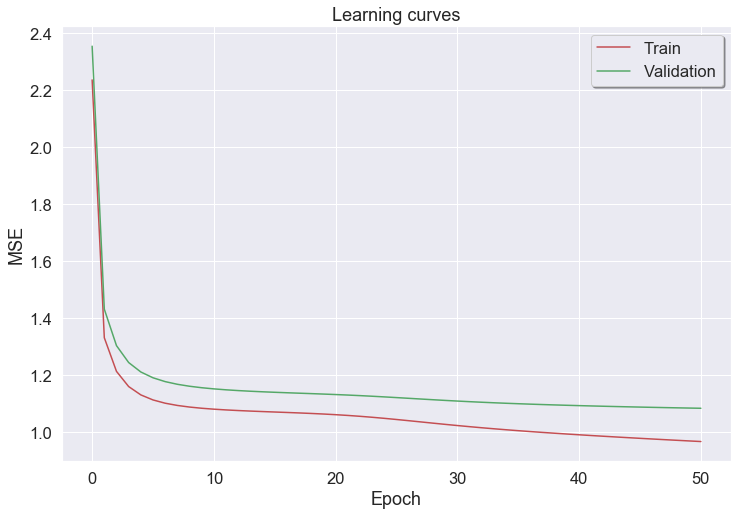

In [22]:
x = list(range(len(loss_train)))
k=0

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)

plt.plot(x[-k:], loss_train[-k:], 'r', label="Train")
plt.plot(x[-k:], loss_valid[-k:], 'g', label="Validation")
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
leg = plt.legend(loc='best', shadow=True, fancybox=True)

##### Question 7

1. Était-ce vraiment nécessaire de calculer autant d'époques?
2. En nous inspirant de ces courbes, quel critère d'arrêt pourrions-nous développer?
3. En quoi est-il plus pertinent que celui défini dans la boucle d'apprentissage?
4. Implémentez-le.

##### Réponse 7

1. En considérant le comportement de la courbe de validation, qui à trois décimales près, ne change plus, visiblement non. 
2. Nous pourrions considérer un critère où l'arrêt d'une amélioration sur l'ensemble de validation provoque un arrêt automatique.
3. Dans la mesure où les modèles en apprentissage automatique cherchent à généraliser, un critère fonction d'un ensemble indépendant à l'ensemble d'entraînement est pertinent.

Enfin, nous pouvons évaluer les performances de notre modèle sur l'ensemble test.

##### Question 8

1. Implémentez la procédure.
2. En quoi est-ce pertinent d'évaluer les performances sur un tel ensemble?

##### Réponse 8

2. Les résultats sur l'ensemble de test sont utilisés comme étalon-or en apprentissage automatique. En fait, dans la littérature notamment, ils permettent de mesurer la capacité des modèles à généraliser.

In [23]:
# Réponse 7.1
loss(test, P, Q)

1.1238161458260751

## 2.4 Analyse

**! Remarque !**

Bien que cette section soit particulièrement intéressante, vous pouvez directement aller à la Section 3 s'attardant davantage au côté algorithmique d'une recommandation. Vous pourrez revenir à cette section une fois l'atelier sur la factorisation matricielle complété.

### 2.4.1 Exploration des couches latentes

Grâce à la factorisation matricielle, il est possible d'explorer les différentes variables latentes associées aux usagers et aux items. De par la nature des matrices $\mathbf{P}$ et $\mathbf{Q}$, l'exploration des <i>k</i> variables latentes associées aux colonnes de $\mathbf{P}$ et $\mathbf{Q}$ pourraient s'avérer intéressante. 

À titre d'exemple, supposons que les deux premières variables latentes de la matrice des objets $\mathbf{Q}$ présentent les valeurs suivantes: 

$$
\begin{align}
q_1 &= [-1.0, \ -0.8, \ 0.0, \ ..., \ 1.0, \ 0.5 ] 
\qquad \text{et} \qquad
q_2 = [-1.0, \ 0.8,  \ 1.0, \ ..., \ 0.5, \ -0.8 ].
\end{align}
$$

Enfin, supposons qu'à ces valeurs correspondent les films suivants: 

1. The Room (2003),
2. Star Wars: Attack of the clones (2002),
3. Titanic (1997),
4. Citizen Kane (1954),
5. The Nigthmare before Christmass (1993).

En cartographiant ces films en fonctions des valeurs associées des deux premières variables latentes, nous obtenons le graphique suivant:

<img src="../Images/hidden.png" width="500">

Après un rapide coup d'oeil, nous pouvons constater que la première variable latente est associée à l'accueil critique du film, alors que la deuxième variable détecte quant à elle la présence d'une super vedette. Si cette première analyse peut nous sembler intéressante, mais quelconque, elle prendra davantage de sens une fois couplée avec les valeurs associées à la matrice des usagers $\mathbf{P}$. Supposons maintenant que les deux premières variables latentes de la matrice des usagers $\mathbf{P}$ présentent les valeurs suivantes: 

$$
\begin{align}
p_1 &= [1.0, \ 0.0, \ -0.5, \ ..., \ 1.0, \ -1.0 ] 
\qquad \text{et} \qquad
p_2 = [1.0, \ 0.0,  \ 0.5, \ ..., \ -1.0, \ -0.8 ].
\end{align}
$$

Et qu'à ces valeurs correspondent les usagers suivants: 

1. Serena,
2. Kali,
3. Neil,
4. Marie,
5. David.

Nous pourrons dès lors cartographier les usagers en fonction des valeurs associées à $p_1$ et $p_2$ tout en conservant la caractérisation des axes que nous avons obtenue auparavant:

<img src="../Images/hidden_2.png" width="500">

Cette façon de faire pourrait nous permettre de suggérer de nouveaux films n'ayant jamais été évalués aux usagers simplement en fonction de certaines caractéristiques. Par exemple, il y a de bonnes chances que Serena aime le prochain film de Scorsese <i>The Irish man</i> et que Neil attende avec impatience le nouveau <i>Cat</i>.

Nous proposons donc une fonction facilitant l'exploration des variables latentes. Considérant le commentaire en lien avec la fréquence de visualisation des films à la Section 1.4.3, nous allons seulement nous intéresser aux films présentant une fréquence de visualisation supérieure à un seuil choisi.

In [24]:
def exploration(object_name, matrix, freq, factor, k):
    """
    Args:
       object_name: vecteur des noms des films
       matrix: matrice latente associée aux films
       freq: seuil de fréquence de visionnement minimal au-delà duquel nous pouvons 
             considérer le film dans l'analyse
       factor: le numéro de la variable latente que l'on veut étudier
       k: nombre de films en sortie = 3*k - 1
       
    Returns:
        names: le titre des films
        scores: l'évaluation prédite associée
        """
    values = matrix[:, factor] * freq
    names, scores = utl.rearrange(object_name, values)
    nonzero = np.nonzero(scores)
    
    start = nonzero[0][0]    
    center = int((len(object_name) - start) / 2)
    
    names = names[start: (start+k) ] + names[(start+center - 1):(start+ center + 2)] +
            names[-k:]
    scores = scores[start : (start+k) ] +
             scores[(start+center - 1):(start+ center + 2)] + 
             scores[-k:]
    
    return names, scores

Nous appelons la fonction et visualisons les résultats.

##### Question 9

1. Est-ce que certaines variables latentes peuvent être interprétables?
2. Qu'arrivera-t-il si nous augmentons le nombre de variables latentes? Si nous le diminuons?

##### Réponse 9

1. Essentiellement, c'est ce qu'on souhaiterait. Cette idée est très bien présentée dans cet <a href="https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf"> article</a>. Par contre, ce n'est pas garanti et un semblant d'interprétation sera fonction du nombre de variables latentes et des données entre autres choses.
2. Cela va dépendre. En fait, il faut bien comprendre que les modèles latents ne sont pas emboîtés les uns dans les autres. Par exemple, les <i>k</i> variables latentes d'un modèle ne vont pas contenir exactement la même information que les <i>k</i> premières variables latentes d'un modèle comportant un plus grand nombre de variables latentes.

In [25]:
k = 2
factor = 0
threshold = 0.1
names, scores = exploration(movies['Title'], Q, 
                            np.where(movie_frequency > threshold, 1, 0), factor, k)

df = pd.DataFrame(np.matrix((names, scores)).T, (np.arange(len(scores)) + 1).tolist())
df.columns = ['Title', 'Latent factor']
df

,Title,Latent factor
1,Beavis and Butt-head Do America (1996),0.03429799874455539
2,Mars Attacks! (1996),0.12047001447554043
3,Natural Born Killers (1994),0.355898819464024
4,"Birdcage, The (1996)",0.3568462618042905
5,Four Weddings and a Funeral (1994),0.35758081156537525
6,Fantasia (1940),0.5085542495454041
7,Braveheart (1995),0.5399751580151742


# 3. Applications 

L'un des objectifs premiers des systèmes de recommandation est d'effectuer des recommandations (!) personnalisées pour chacun des utilisateurs. Dès lors, il pourrait être intéressant d'étudier les recommandations effectuées par notre modèle pour un individu spécifique. Naturellement, les recommandations faites ne suggèrent que des films non visionnés par l'usager.

##### Question 10

1. Nous allons maintenant, pour un usager choisi, effectuer les 10 meilleures recommandations associées. Pour ce faire, nous allons procéder par étapes simples telles que présentées dans le code. Notez que la fonction maison `rearrange` présentée ci-dessous pourrait vous être utile.

In [26]:
"""
Description:  
Pour un ensemble de valeurs numériques (le paramètre ratings) auquel est associé un
autre ensemble de même longueur (le paramètre names) numérique ou non, la fonction 
trie en ordre croissant ratings tout en conservant la correspondance avec l'objet names

p.ex.:
a, b = ['a', 'b', 'c'], [6,1,3]
rearrange(a, b)
"""

def rearrange(names, ratings):
    attribute, scores = [], []
    ranking = np.argsort(ratings)

    for k in np.arange(len(ranking)):
        attribute.append(names[ranking[k]])
        scores.append(ratings[ranking[k]])

    return attribute, scores

In [27]:
user_id = 0
top_what = 10

# Étape 1: Définir quels films ont déjà été visionnés dans chacun des sous-ensembles
user_train, user_valid, user_test = np.array(train[0][user_id]), 
                                    np.array(train[1][user_id]), 
                                    np.array(test[user_id])
user_train, user_valid, user_test = np.where(user_train > 0, 1, 0), 
                                    np.where(user_valid > 0, 1, 0), 
                                    np.where(user_test > 0, 1, 0)

# Étape 2: Calculez l'ensemble des évaluations prédites pour l'individu choisi
estimate = np.dot(P[user_id, :], Q.T)

# Étape 3: Considérez seulement les évaluations associées aux ensembles 
#      d'entraînement et de validation
estimate_train, estimate_valid = estimate * user_train, estimate * user_valid

# Étape 4: Réorganisez les estimations sur les différents ensembles de manière à proposer 
#          les 10 meilleures recommandations
recommendations, scores = rearrange(np.array(movies['Title']), estimate_valid)
recommendations, scores = recommendations[-top_what:], scores[-top_what:]

# Présentations des recommandations
df = pd.DataFrame(np.matrix((recommendations, scores)).T, (np.arange(10) + 1).tolist())
df.columns = ['Title', 'Predicted rating']
df

,Title,Predicted rating
1,On Golden Pond (1981),3.682480520229741
2,Lone Star (1996),3.715009756072107
3,Snow White and the Seven Dwarfs (1937),3.8887049344850873
4,"Spitfire Grill, The (1996)",3.9400592641887062
5,"Terminator, The (1984)",3.9583289042467507
6,Sneakers (1992),3.981500529283176
7,Belle de jour (1967),4.022776915670769
8,Nikita (La Femme Nikita) (1990),4.0900238347237625
9,Priest (1994),4.276362974978491
10,Three Colors: Red (1994),4.636652992241622


En manipulant rapidement le code ci-dessus, on s'aperçoit que les évaluations sur les prédictions sur les ensembles d'entraînement, de validation et même de test sont vraisemblables. Effectivement, ces dernières se situent entre 0 et 5, tout semble alors en ordre, ce qui nous paraît "normal" puisque les EQM sur les ensembles d'entraînement et de validation n'étaient pas particulièrement élevées.

En fait, ça pourrait être intéressant de proposer à l'usager des films en fonction de ces préférences du moment en fonction du genre.

##### Question 11

1. Écrivez une fonction permettant d'effectuer pareille tâche.

In [28]:
def recommendations(user_id, data, P, Q, movies_genre, genre, new):
    """
    Args:
       user_id: user_id
       data: ensemble des évaluations
       P: matrice des invidus
       Q: matrices des items
       movies_genre: genre de film que l'utilisateur user_id veut écouter
       new: Booléen, voulons-nous effectuer de nouvelles recommandations ou pas?
    
    Returns:
        les meilleures suggestions en fonction du genre de film sélectionné
    """
    
    place = movies_genre_name.tolist().index(genre)    
    genre = np.array(movies_genre[:, place])
    predictions = np.array(np.dot(P[user_id, :], Q.T))
    
    #if new:
    #    return np.array(predictions) * np.array(genre.T)[0] * np.where(data == 1, 0, 1)
    
    return np.array(predictions) * np.array(genre.T)[0]

In [29]:
genre = "Animation"
top_what = 5

# Calcul et réorganisation des recommandations
estimate = recommendations(user_id, train, P, Q, movies_genre, genre, False)
suggestions, scores = rearrange(np.array(movies['Title']), estimate)

# Présentations des recommandations
df = pd.DataFrame(np.matrix((suggestions[-top_what:], scores[-top_what:])).T, 
                  (np.arange(top_what) + 1).tolist())
df.columns = ['Title', 'Predicted rating']
df

,Title,Predicted rating
1,Wallace & Gromit: The Best of Aardman Animatio...,4.4155138874339475
2,Faust (1994),4.525889680745223
3,Ghost in the Shell (Kokaku kidotai) (1995),4.638998063824521
4,"Close Shave, A (1995)",4.72169078411614
5,"Wrong Trousers, The (1993)",4.814688439702117
